# Hidden Markov Model (HMM) Regime Switching Analysis - Summary

This notebook implements a 3-state Hidden Markov Model (HMM) to identify market regimes in the S&P 500 between 2005 and present. The motivation for using an HMM is that market regimes (bull, bear, crash) cannot be directly observed, but their characteristics are reflected in underlying data such as returns and volatility. HMMs are effective at detecting regime shifts earlier than traditional indicators because they infer state probabilities dynamically.

## Model Specification

States: Bull, Bear, Crash

Observation model: Gaussian emissions on daily log-returns

### Initial state probabilities:

Bull: 0.4

Bear: 0.3

Crash: 0.3

### Initial transition matrix:

Bull → [0.80, 0.15, 0.05]

Bear → [0.20, 0.65, 0.15]

Crash → [0.50, 0.40, 0.10]

These initial values were slightly adjusted during tuning but broadly preserved the expected dynamics (e.g., bullish persistence, crash-to-bear transitions).

## Evaluation

The model successfully identified major downturns in 2008, 2020, 2022, and April 2025.

The filtered regime probabilities show:

Bear as the most frequent long-run state (consistent with extended drawdown and stagnation periods)

Crash as short-lived but high-variance episodes aligned with market stress

Bull as prolonged positive-return sequences

The regime-conditioned return distributions were clearly separated:

Bull: positive, lower variance

Bear: mildly negative

Crash: strongly negative, highest variance

The purpose of the project was structural understanding rather than strategy construction, so the HMM was not converted into a trading system, although the outputs would lend themselves to regime-aware allocation.



In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import hmmlearn as hl 

In [21]:
regimes = { 
    0 : "Bullish",
    1 : "Bearish",
    2 : "Crash"
}
regimes

{0: 'Bullish', 1: 'Bearish', 2: 'Crash'}

In [22]:
#Init vals 

transition_matr = np.array([
    [0.8, 0.15, 0.05], # Bullish
    [0.2, 0.65,0.15], #Bearish
    [0.5,0.4,0.1] # Crash
])

pi_init = np.array([
    [0.4,0.3,0.3]])
pi_init, transition_matr

(array([[0.4, 0.3, 0.3]]),
 array([[0.8 , 0.15, 0.05],
        [0.2 , 0.65, 0.15],
        [0.5 , 0.4 , 0.1 ]]))

In [23]:
start = "2005-01-01"
end = "2025-11-24"
df = yf.download("SPY", start= start, end = end, threads = True
                  ,rounding = False, auto_adjust = False)
df["Return"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
returns = df["Return"].dropna().values.reshape(-1,1)
returns

[*********************100%***********************]  1 of 1 completed


array([[-0.01229513],
       [-0.00692385],
       [ 0.00507128],
       ...,
       [ 0.00385571],
       [-0.01535961],
       [ 0.00991194]], shape=(5256, 1))

# Bucketisation of the returns in order to find the means and variances of each regime. 

In [24]:
import math
n_regimes = 3 

In [25]:
edges = np.quantile(returns, np.linspace(0,1, n_regimes+ 1))
bucket_indices = np.digitize(returns, edges[1:-1])

means = np.zeros(n_regimes)
variances = np.zeros(n_regimes)

for i in range(n_regimes):
    mask = (bucket_indices == i)
    means[i] = returns[mask].mean()
    variances[i] = returns[mask].var()

means, variances

(array([-0.01062966,  0.00082422,  0.01099603]),
 array([1.13082982e-04, 2.51764546e-06, 8.46378896e-05]))

In [26]:
from hmmlearn.hmm import GaussianHMM as GHMM


In [27]:
model = GHMM(n_components=3, covariance_type = "spherical",algorithm = "viterbi", n_iter = 10**7, means_prior = means, covars_prior = variances, random_state = 42, startprob_prior = pi_init[0], transmat_prior = transition_matr)


In [28]:
model.fit(returns)
pi = model.get_stationary_distribution()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: divide by zero encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: overflow encountered in matmul
  current_pot = closest_dist_sq @ sample_weight
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:237: RuntimeWarning: invalid value encountered in matmul
  current_pot = closest_dist_sq @ sample_weight


In [29]:
pi

array([0.32779757, 0.39893271, 0.27326971])

In [30]:
model.predict(returns)

array([1, 0, 1, ..., 1, 2, 1], shape=(5256,))

In [31]:

import math
def gaussian_pdf(stock_return, mean, standard_deviation):
    return (1/(standard_deviation*math.sqrt(2* math.pi)))*math.e**(-1/2)*(((stock_return - mean) / standard_deviation)**2)

## Now it is time to develop the forward-backward algorithm. 
The forward-backward algorithm requires a number of parameters;

The observations, the possible regimes, 
the initial probability of those regimes, 
the initial transition probability, 
the emission probability, commonly denoted as π
the end step (number of steps) 

The observations for the S&P will be the returns from each day. 
The initial probabilities have been determined via the bucketisation denoted above.

In [32]:
def f_b_a(stock_returns, possible_regimes, prob_intl, trans_intl, pi, means, variances):
    total_num_of_returns = len(stock_returns)
    total_regimes = len(possible_regimes)
    emissions = np.zeros((total_num_of_returns, total_regimes))
    for t in range (total_num_of_returns):
        for j in range (total_regimes):
            mu = means[j]
            sigma = np.sqrt(variances[j])

            emissions[t,j] = gaussian_pdf(stock_returns[t], mu, sigma)
            

    alpha = np.zeros((total_num_of_returns, total_regimes))
    alpha[0] = pi * emissions[0]
    alpha[0] = alpha[0] / np.sum(alpha[0])


    # Forward Algorithm
    
    for t in range (1, total_num_of_returns):
        for j in range (total_regimes):
            sum_prev = 0
            for i in range (total_regimes):
                sum_prev += alpha[t-1, i] * trans_intl[i, j] 
            alpha[t,j] = sum_prev * emissions[t,j] 
        alpha[t] = alpha[t] / np.sum(alpha[t])



    # Backward Algorithm

    beta = np.zeros((total_num_of_returns, total_regimes)) 
    beta[total_num_of_returns-1, :] = 1
    
    for t in range(total_num_of_returns -2, -1, -1):
        for i in range (total_regimes):
            sum_next = 0
            for j in range(total_regimes):
                sum_next += trans_intl[i, j] * emissions[t+1, j] * beta[t+1,j]
            beta[t,i] = sum_next
            
        beta[t] = beta[t] / np.sum(beta[t])


    gamma = alpha * beta
    gamma = gamma / gamma.sum(axis=1, keepdims=True)
    return gamma 



/var/folders/7g/5n3bdh0x0m7b51sktmznz0dw0000gn/T/ipykernel_8096/1539969079.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  emissions[t,j] = gaussian_pdf(stock_returns[t], mu, sigma)


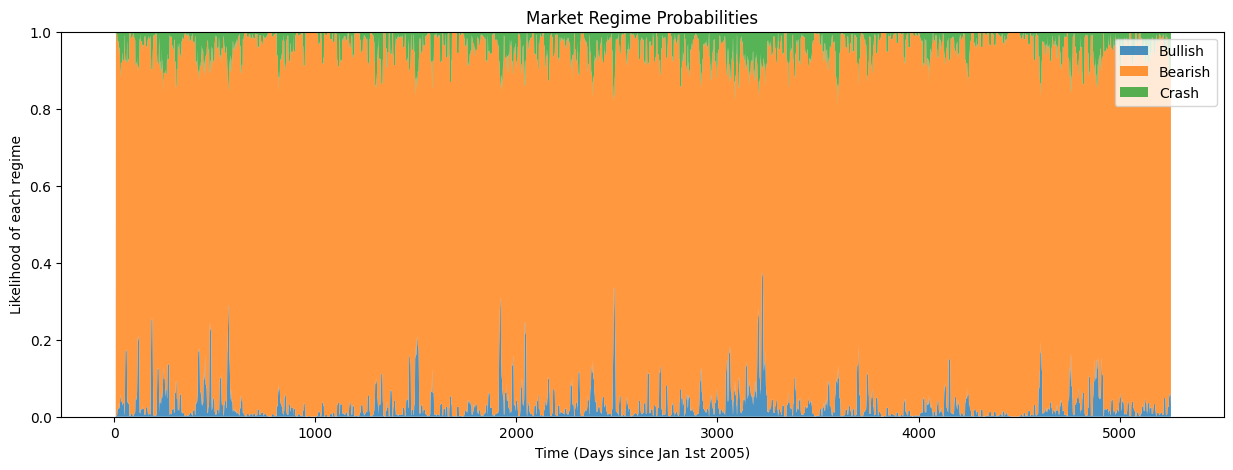

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

gamma = f_b_a(returns, regimes, pi_init, transition_matr, pi, means, variances)

smooth_gamma = pd.DataFrame(gamma).rolling(10).mean().fillna(0)

time_steps = range(len(smooth_gamma))          # use all time steps
data_to_plot = smooth_gamma.T                  # each row = regime

plt.figure(figsize=(15, 5))
plt.stackplot(time_steps, data_to_plot, labels=regimes.values(), alpha=0.8, linewidth=2)

plt.title("Market Regime Probabilities")
plt.xlabel("Time (Days since Jan 1st 2005)")
plt.ylabel("Likelihood of each regime")
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.show()